In [1]:
import matplotlib.pyplot as plt
import numpy as np

## データのロード

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [3]:
train_data.shape, train_targets.shape

((404, 13), (404,))

In [4]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [5]:
train_targets[0]

15.2

## データの準備

### 入力データの変換(正規化)

In [6]:
def standardize(train_data, test_data):
    train_data_mean = train_data.mean(axis=0)
    train_data_std  = train_data.std(axis=0)

    X_trainval = (train_data - train_data_mean) / train_data_std
    X_test  = (test_data  - train_data_mean) / train_data_std

    return X_trainval, X_test

In [7]:
X_trainval, X_test = standardize(train_data, test_data)

print(X_trainval.mean(), X_trainval.std())
print(X_test.mean(), X_test.std())

2.6016254395785847e-15 0.9999999999999993
0.020826991430640224 0.9836083446422431


In [8]:
# 名前をあわせておく
y_trainval = train_targets
y_test = test_targets

## ネットワークの構築

In [9]:
from keras import backend, layers, models

def build_model():
    """交差検証で使い回すのでネットワーク構築とコンパイルを関数化"""
    backend.clear_session()

    # 層の内部構成を分かりやすくするためにあえて冗長に記述する
    model = models.Sequential()

    # 隠れ層その1
    model.add(layers.Dense(units=64, input_shape=(13,), name="Hidden_1"))
    model.add(layers.Activation("relu", name="ReLU_1"))

    # 隠れ層その2
    model.add(layers.Dense(units=64, name="Hidden_2"))
    model.add(layers.Activation("relu", name="ReLU_2"))

    # 出力層(そのまま出力すればいいので活性化関数は不要)
    model.add(layers.Dense(units=1, name="Output"))

    # モデルのコンパイル
    model.compile(optimizer="rmsprop",
                  loss="mse",
                  metrics=["mae"])

    return model

In [10]:
# ネットワーク構成を確認しておく
model = build_model()

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_1 (Dense)             (None, 64)                896       
_________________________________________________________________
ReLU_1 (Activation)          (None, 64)                0         
_________________________________________________________________
Hidden_2 (Dense)             (None, 64)                4160      
_________________________________________________________________
ReLU_2 (Activation)          (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## データが少ないので交差検証

In [11]:
from sklearn.model_selection import KFold

k = 4
num_epochs = 500

ss = KFold(n_splits=k, shuffle=True)

mae_histories = []

for i, (train_index, val_index) in enumerate(ss.split(X_trainval, y_trainval)):
    print(f"k = {i}")
    X_train = X_trainval[train_index]
    X_val = X_trainval[val_index]

    y_train = y_trainval[train_index]
    y_val = y_trainval[val_index]

    model = build_model()

    history = model.fit(X_train,
                        y_train,
                        epochs=num_epochs,
                        batch_size=1,
                        validation_data=(X_val, y_val),
                        verbose=0)

    val_mae = history.history["val_mean_absolute_error"]
    mae_histories.append(val_mae)

k = 0
k = 1
k = 2
k = 3


In [12]:
mae_histories_ndarray = np.array(mae_histories)

mae_histories_ndarray

array([[4.06752141, 2.76050516, 2.63363156, ..., 2.81231883, 2.68944363,
        2.66535457],
       [3.73633979, 3.13439561, 2.70457382, ..., 2.4231619 , 2.40575721,
        2.43245111],
       [4.37801676, 3.32769972, 3.17282965, ..., 2.92366477, 2.92694535,
        2.86491547],
       [4.55028342, 3.99918232, 3.67881341, ..., 2.88369592, 3.03043734,
        2.82062596]])

In [13]:
average_mae_history = mae_histories_ndarray.mean(axis=0)

average_mae_history

array([4.18304035, 3.3054457 , 3.04746211, 2.890766  , 2.74165398,
       2.69757682, 2.52423953, 2.5228487 , 2.46909358, 2.531756  ,
       2.46228638, 2.51302483, 2.45031739, 2.47083539, 2.43763318,
       2.40721318, 2.55070865, 2.44484637, 2.50150789, 2.46539895,
       2.55043035, 2.44981243, 2.41028443, 2.58111226, 2.33616665,
       2.48632446, 2.39042948, 2.26060019, 2.28270627, 2.36108792,
       2.40481295, 2.57598902, 2.37729072, 2.43955437, 2.38383941,
       2.43308576, 2.38399083, 2.38501971, 2.490651  , 2.54843549,
       2.44447374, 2.36014161, 2.53004084, 2.24971956, 2.43227029,
       2.27607976, 2.29438477, 2.49825864, 2.39641041, 2.59983999,
       2.40218762, 2.39327858, 2.37147026, 2.27805657, 2.30465602,
       2.3794417 , 2.47009674, 2.28591753, 2.46678883, 2.39655404,
       2.46165498, 2.26514649, 2.36210186, 2.35733389, 2.30775703,
       2.43380801, 2.32469805, 2.36124982, 2.47877772, 2.494331  ,
       2.49206251, 2.35576068, 2.56349239, 2.39197009, 2.54860

## 可視化

### 素直にMAEを可視化

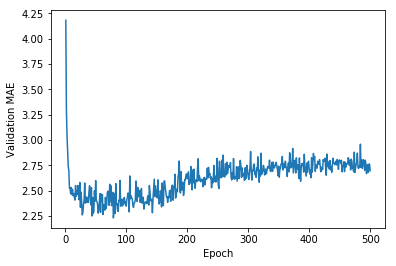

In [14]:
plt.plot(range(1, num_epochs + 1),  average_mae_history)

plt.xlabel("Epoch")
plt.ylabel("Validation MAE")

plt.show()

### 移動平均線で考える

In [15]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []

    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)

    return smoothed_points

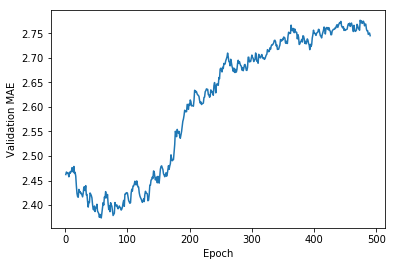

In [16]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1),  smooth_mae_history)

plt.xlabel("Epoch")
plt.ylabel("Validation MAE")

plt.show()

## 最終的なモデルの訓練

In [17]:
model_final = build_model()

model_final.fit(X_trainval,
                y_trainval,
                epochs=80,
                batch_size=16,
                verbose=1)

Epoch 1/80
404/404 [==============================] - 0s 303us/step - loss: 530.8924 - mean_absolute_error: 20.8744
Epoch 2/80
404/404 [==============================] - 0s 42us/step - loss: 392.2445 - mean_absolute_error: 17.2505
Epoch 3/80
404/404 [==============================] - 0s 41us/step - loss: 229.5682 - mean_absolute_error: 12.3719
Epoch 4/80
404/404 [==============================] - 0s 41us/step - loss: 110.6835 - mean_absolute_error: 7.9178
Epoch 5/80
404/404 [==============================] - 0s 40us/step - loss: 62.8145 - mean_absolute_error: 5.6605
Epoch 6/80
404/404 [==============================] - 0s 41us/step - loss: 41.6108 - mean_absolute_error: 4.5021
Epoch 7/80
404/404 [==============================] - 0s 42us/step - loss: 30.2890 - mean_absolute_error: 3.8507
Epoch 8/80
404/404 [==============================] - 0s 41us/step - loss: 24.2047 - mean_absolute_error: 3.3834
Epoch 9/80
404/404 [==============================] - 0s 41us/step - loss: 20.7224 - mea

404/404 [==============================] - 0s 42us/step - loss: 6.3726 - mean_absolute_error: 1.8284
Epoch 74/80
404/404 [==============================] - 0s 41us/step - loss: 6.3165 - mean_absolute_error: 1.8143
Epoch 75/80
404/404 [==============================] - 0s 41us/step - loss: 6.4116 - mean_absolute_error: 1.8442
Epoch 76/80
404/404 [==============================] - 0s 44us/step - loss: 6.2446 - mean_absolute_error: 1.7828
Epoch 77/80
404/404 [==============================] - 0s 43us/step - loss: 6.2911 - mean_absolute_error: 1.7964
Epoch 78/80
404/404 [==============================] - 0s 42us/step - loss: 6.2564 - mean_absolute_error: 1.8000
Epoch 79/80
404/404 [==============================] - 0s 42us/step - loss: 6.1019 - mean_absolute_error: 1.7776
Epoch 80/80
404/404 [==============================] - 0s 41us/step - loss: 6.3005 - mean_absolute_error: 1.7855


In [18]:
test_mse_score, test_mae_score = model_final.evaluate(X_test, y_test)

102/102 [==============================] - 0s 182us/step


In [19]:
# 2,500ドルくらいずれている
test_mae_score

2.9285620240604175